In [49]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import nltk
import os
import pandas as pd

from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import mean_squared_error

In [8]:
TRAIN_DATA = './datasets/sts-train.csv'
TEST_DATA = './datasets/sts-test.csv'
CWD = os.getcwd()

In [30]:
sts_dev = pd.read_table(
    TRAIN_DATA,
    error_bad_lines=False,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["similarity", "S1", "S2"])

sts_test = pd.read_table(
    TEST_DATA,
    error_bad_lines=False,
    quoting=csv.QUOTE_NONE,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["similarity", "S1", "S2"])

In [31]:
train_df = pd.concat([sts_dev, sts_test])

In [32]:
len(train_df)

7090

In [34]:
train_df['S2'] = [str(x) for x in train_df['S2']]

In [35]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
# embeddings produce a 512-length vector representing the sentence context
sample = train_df['S1'][0]
print (sample)
message_embeddings = embed([sample])
print (message_embeddings.shape)

0         A plane is taking off.
0    A girl is styling her hair.
Name: S1, dtype: object


### Qualitatively Evaluate Embeddings on a Small Sample by Plotting a Heatmap

In [13]:
# given sentence pairs that have been evaluated together create a heatmap
# features = sentence embeddings, labels = sentences
# first half corresponds to second half
def plot_similarity(labels, features, rotation):
    M = int(len(features) / 2)
    text_cutoff = 50
    
    labels = [label[:text_cutoff] for label in labels]
    corr = np.inner(features[:M], features[M:])
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels[:M],
      yticklabels=labels[M:],
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels[:M], rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    g.get_figure().savefig("./sonia-mannan-sentence-embeddings-results/sample_heatmap.png", bbox_inches='tight')

def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

S(0         A plane is taking off.
0    A girl is styling her hair.
Name: S1, dtype: object, 0     An air plane is taking off.
0    A girl is brushing her hair.
Name: S2, dtype: object) = 5.0
S(1             A man is playing a large flute.
1    A group of men play soccer on the beach.
Name: S1, dtype: object, 1                           A man is playing a flute.
1    A group of boys are playing soccer on the beach.
Name: S2, dtype: object) = 3.8
S(2    A man is spreading shreded cheese on a pizza.
2    One woman is measuring another woman's ankle.
Name: S1, dtype: object, 2    A man is spreading shredded cheese on an uncoo...
2              A woman measures another woman's ankle.
Name: S2, dtype: object) = 3.8
S(3       Three men are playing chess.
3    A man is cutting up a cucumber.
Name: S1, dtype: object, 3      Two men are playing chess.
3    A man is slicing a cucumber.
Name: S2, dtype: object) = 2.6
S(4    A man is playing the cello.
4       A man is playing a harp.
Name: S1, dt

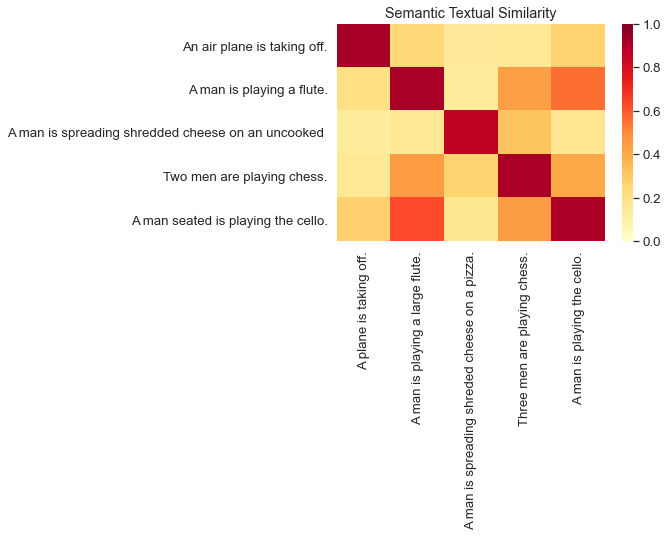

In [14]:
messages = list(train_df['S1'][:5]) + list(train_df['S2'][:5])
similarities = train_df['similarity'][:5]
for i in range(len(similarities)):
    print ('S({0}, {1}) = {2}'.format(train_df['S1'][i], train_df['S2'][i], similarities[i]))
run_and_plot(messages)

### Quantitively Evaluate Embeddings by Calculating Cosine Similarities

In [15]:
def magnitude(e1):
    return np.sqrt(np.sum(np.square(e1)))

In [16]:
def cosine_similarity(e1, e2):
    return (np.dot(e1, e2) / (magnitude(e1) * magnitude(e2)))

In [36]:
assert train_df['similarity'].shape[0] == train_df['S2'].shape[0] == train_df['S1'].shape[0]

# get embeddings for each sentence pair, 5,749 x 512
e1 = tf.nn.l2_normalize(embed(train_df['S1']), axis=1)
e2 = tf.nn.l2_normalize(embed(train_df['S2']), axis=1)

# take the cosine similarity between each embedding
calculated_similarities = np.array([cosine_similarity(x, y) for x, y in zip(e1, e2)])
actual_scores = train_df['similarity']

# calculate the pearson correlation
pearson_correlation = pearsonr(calculated_similarities, actual_scores)

### Pearson correlation measures similarity between two variables
1. -1 = opposite, 0 = neatral, 1 = same -> higher score means they are more similar. We expect the correlation between calculated and real scores to be high
2. Without dropping malformed lines: 0.64
3. With dropping malformed lines: 0.778


In [37]:
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Pearson correlation coefficient = 0.7784817445535114
p-value = 0.0


#### We can also calculate the RMSE between calculated and real scores by interpolating calculated scores between 0-5
1. Perfect RMSE = 0
2. Random RMSE = 2.1492 -> randomly generate an array of 0-5
3. Actual RMSE = 1.167 -> not perfect but better than randomly guessing
4. Actual RMSE drop lines = 1.195

In [41]:
calculated_scores = np.interp(calculated_similarities, (calculated_similarities.min(), \
                                                        calculated_similarities.max()), (0, +5))
print ('Actual RMSE', mean_squared_error(actual_scores, calculated_scores, squared=False))

Actual RMSE 1.1954601701698726


In [42]:
print ('Perfect RMSE', mean_squared_error(actual_scores, actual_scores, squared=False))

Perfect RMSE 0.0


In [43]:
print ('Random RMSE', mean_squared_error(actual_scores, np.random.randint(5, size=len(actual_scores)), squared=False))

Random RMSE 2.162028148244892


### K-Means clustering using the embeddings
1. If the embeddings represent sentences well, similar sentences should be in the same cluster and non-similars should be in different ones. With 20 clusters:
    - 0.2359081419624217
    - 0.7210144927536232
    - 0.7839721254355401
    - 0.8202531645569621
    - 0.8558951965065502
    - 0.9281767955801105
2. If we cluster all the embeddings are there any clear patterns or topics that arise?
    - Cluster 0: Finance
    - Cluster 1: Syria
    - Cluster 2: unclear
    - Cluster 3: unclear
    - Cluster 4: People Playing Musical Instruments
    - Cluster 5: unclear
    - Cluster 6: Girls and Women
    - Cluster 7: News about the middle east (Afghanistan, Iraq, Saudi Arabia)
    - Cluster 8: Dogs
    - Cluster 9: unclear
    - Cluster 10: Foreign Events
    - Cluster 11: Cats
    - Cluster 12: Cooking
    - Cluster 13: Men
    - Cluster 14: Statements
    - Cluster 15: Foreign Events
    - Cluster 16: Crime
    - Cluster 17: unclear
    - Cluster 18: Mili

In [71]:
# 14,180 x 512 vectors
all_sentences_embeddings = np.vstack((e1.numpy(), e2.numpy()))

In [104]:
def inspect_scores_and_clusters(train_df, all_sentences_embeddings, kmeans, n_clusters):
    real_scores = list(train_df['similarity'])
    all_sentences = list(train_df['S1']) + list(train_df['S2'])
    preds = kmeans.predict(all_sentences_embeddings)

    for cluster in range(n_clusters):
        idxs = np.where(preds == cluster)

        print ('CLUSTER {0} has {1} preds\n'.format(cluster, len(idxs[0])))
        for i in idxs[0][:25]:
            print(all_sentences[i])

        print ('\n--------------------\n')

In [111]:
def find_n_clusters(all_sentences_embeddings, max_clusters=10):
    optimal_clusters = []
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(all_sentences_embeddings)
        optimal_clusters.append(kmeans.inertia_)
        
    plt.plot(range(1, max_clusters+1), optimal_clusters)
    plt.title('The Elbow Method Graph')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.savefig("./sonia-mannan-sentence-embeddings-results/kmeans_cluster_elbow.png", bbox_inches='tight')
    plt.show()

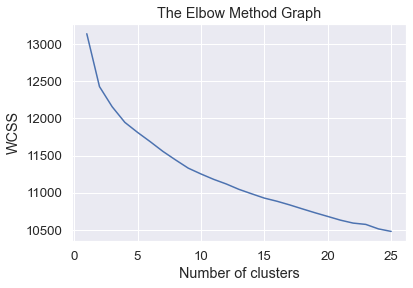

In [145]:
# find the optimal number of clusters to use
find_n_clusters(all_sentences_embeddings, max_clusters=25)

In [141]:
# inspect a few sentences from each cluster
# are there any well-defined patterns?
kmeans = kmeans = KMeans(n_clusters=20)
kmeans.fit(all_sentences_embeddings)
inspect_scores_and_clusters(train_df, all_sentences_embeddings, kmeans, 20)

CLUSTER 0 has 602 preds

The bailout was bigger than TARP Bloomberg news.
Scenario A assumes that the CO growth rate accelerates by .%/yr.
Capital gains, top rate:  percent.
If you want to buy $ billion in XYZ Inc. common stock, who cares?
Capital gains, top rate:  percent.
In afternoon trading in Europe, France's CAC-40 advanced and Britain's FTSE 100 each gained 0.7 percent, while Germany's DAX index rose 0.6 percent.
Earlier this month, RIM had said it expected to report second-quarter earnings of between 7 cents and 11 cents a share.
Shares of Hartford rose $2.88 to $46.50 in New York Stock Exchange composite trading.
Sovereign's shares lost 74 cents, or 4.5%, to $15.68.
Aspen Technology's shares dropped 74 cents, or 23 percent, to close at $2.48 on the Nasdaq.
The broader Standard & Poor's 500 Index .SPX fell 3 points, or 0.30 percent, to 995.
The euro soared to US$1.1914 in Asian trading, before slipping back slightly to US$1.1895 as trading opened in Europe.
Shares of LendingTre

In [142]:
def compare_sentence_predictions(random_score, train_df, e1, e2, kmeans, verbose=False):
    # get the embeddings
    emb1 = e1[random_score]
    emb2 = e2[random_score]

    # get the sentences
    S1 = list(train_df['S1'])[random_score]
    S2 = list(train_df['S2'])[random_score]

    # make a prediction
    preds = kmeans.predict([emb1, emb2])
    if verbose:
        print ('S1 = {0}, S2 = {1}, Predicted Clusters = {2}\n\n'.format(S1, S2, preds))
    
    return preds

In [143]:
def evaluate_cluster_accuracy(train_df, kmeans, e1, e2, target):
    # does the cluster algorithm put two high-similarity sentences within the same cluster?
    all_sentences = list(train_df['S1']) + list(train_df['S2'])
    real_scores = train_df['similarity']

    # find all scores with high similarities
    high_similarities = np.where(train_df['similarity'] == target)[0]
    # choose one randomly
    random_score = np.random.choice(high_similarities)

    compare_sentence_predictions(random_score, train_df, e1, e2, kmeans, verbose=True)

    correct = 0
    for i in high_similarities:
        preds = compare_sentence_predictions(i, train_df, e1, e2, kmeans)
        if preds[0] == preds[1]:
            correct += 1

    print ('Accuracy = {0}'.format(correct / float(len(high_similarities))))

In [144]:
for i in range(6):
    print ('Evaluating score {0}'.format(i))
    evaluate_cluster_accuracy(train_df, kmeans, e1, e2, i)

Evaluating score 0
S1 = Iran, a large important partner for Russia: Novak, S2 = Iran reiterates support for Iraq, Syria, Predicted Clusters = [18  1]


Accuracy = 0.2359081419624217
Evaluating score 1
S1 = Yes, it is possible to publish a paper on model analysis., S2 = Yes, it is hard to publish in a peer reviewed journal., Predicted Clusters = [17 17]


Accuracy = 0.7210144927536232
Evaluating score 2
S1 = That is your problem, not your supervisor's., S2 = Work with your supervisor and your team to solve the problem., Predicted Clusters = [14 17]


Accuracy = 0.7839721254355401
Evaluating score 3
S1 = 7 killed in attacks in Iraq, S2 = 16 killed in series of attacks in Iraq, Predicted Clusters = [7 7]


Accuracy = 0.8202531645569621
Evaluating score 4
S1 = A man is taking out the insides of a green pepper., S2 = Someone is removing the seeds from a bell pepper., Predicted Clusters = [12 12]


Accuracy = 0.8558951965065502
Evaluating score 5
S1 = Two people walking on the beach at sunse